**stable diffusion**

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count()) 
print(torch.cuda.get_device_name(0))    

2.4.1+cu121
True
1
NVIDIA GeForce RTX 3060 Laptop GPU


**archtecture**
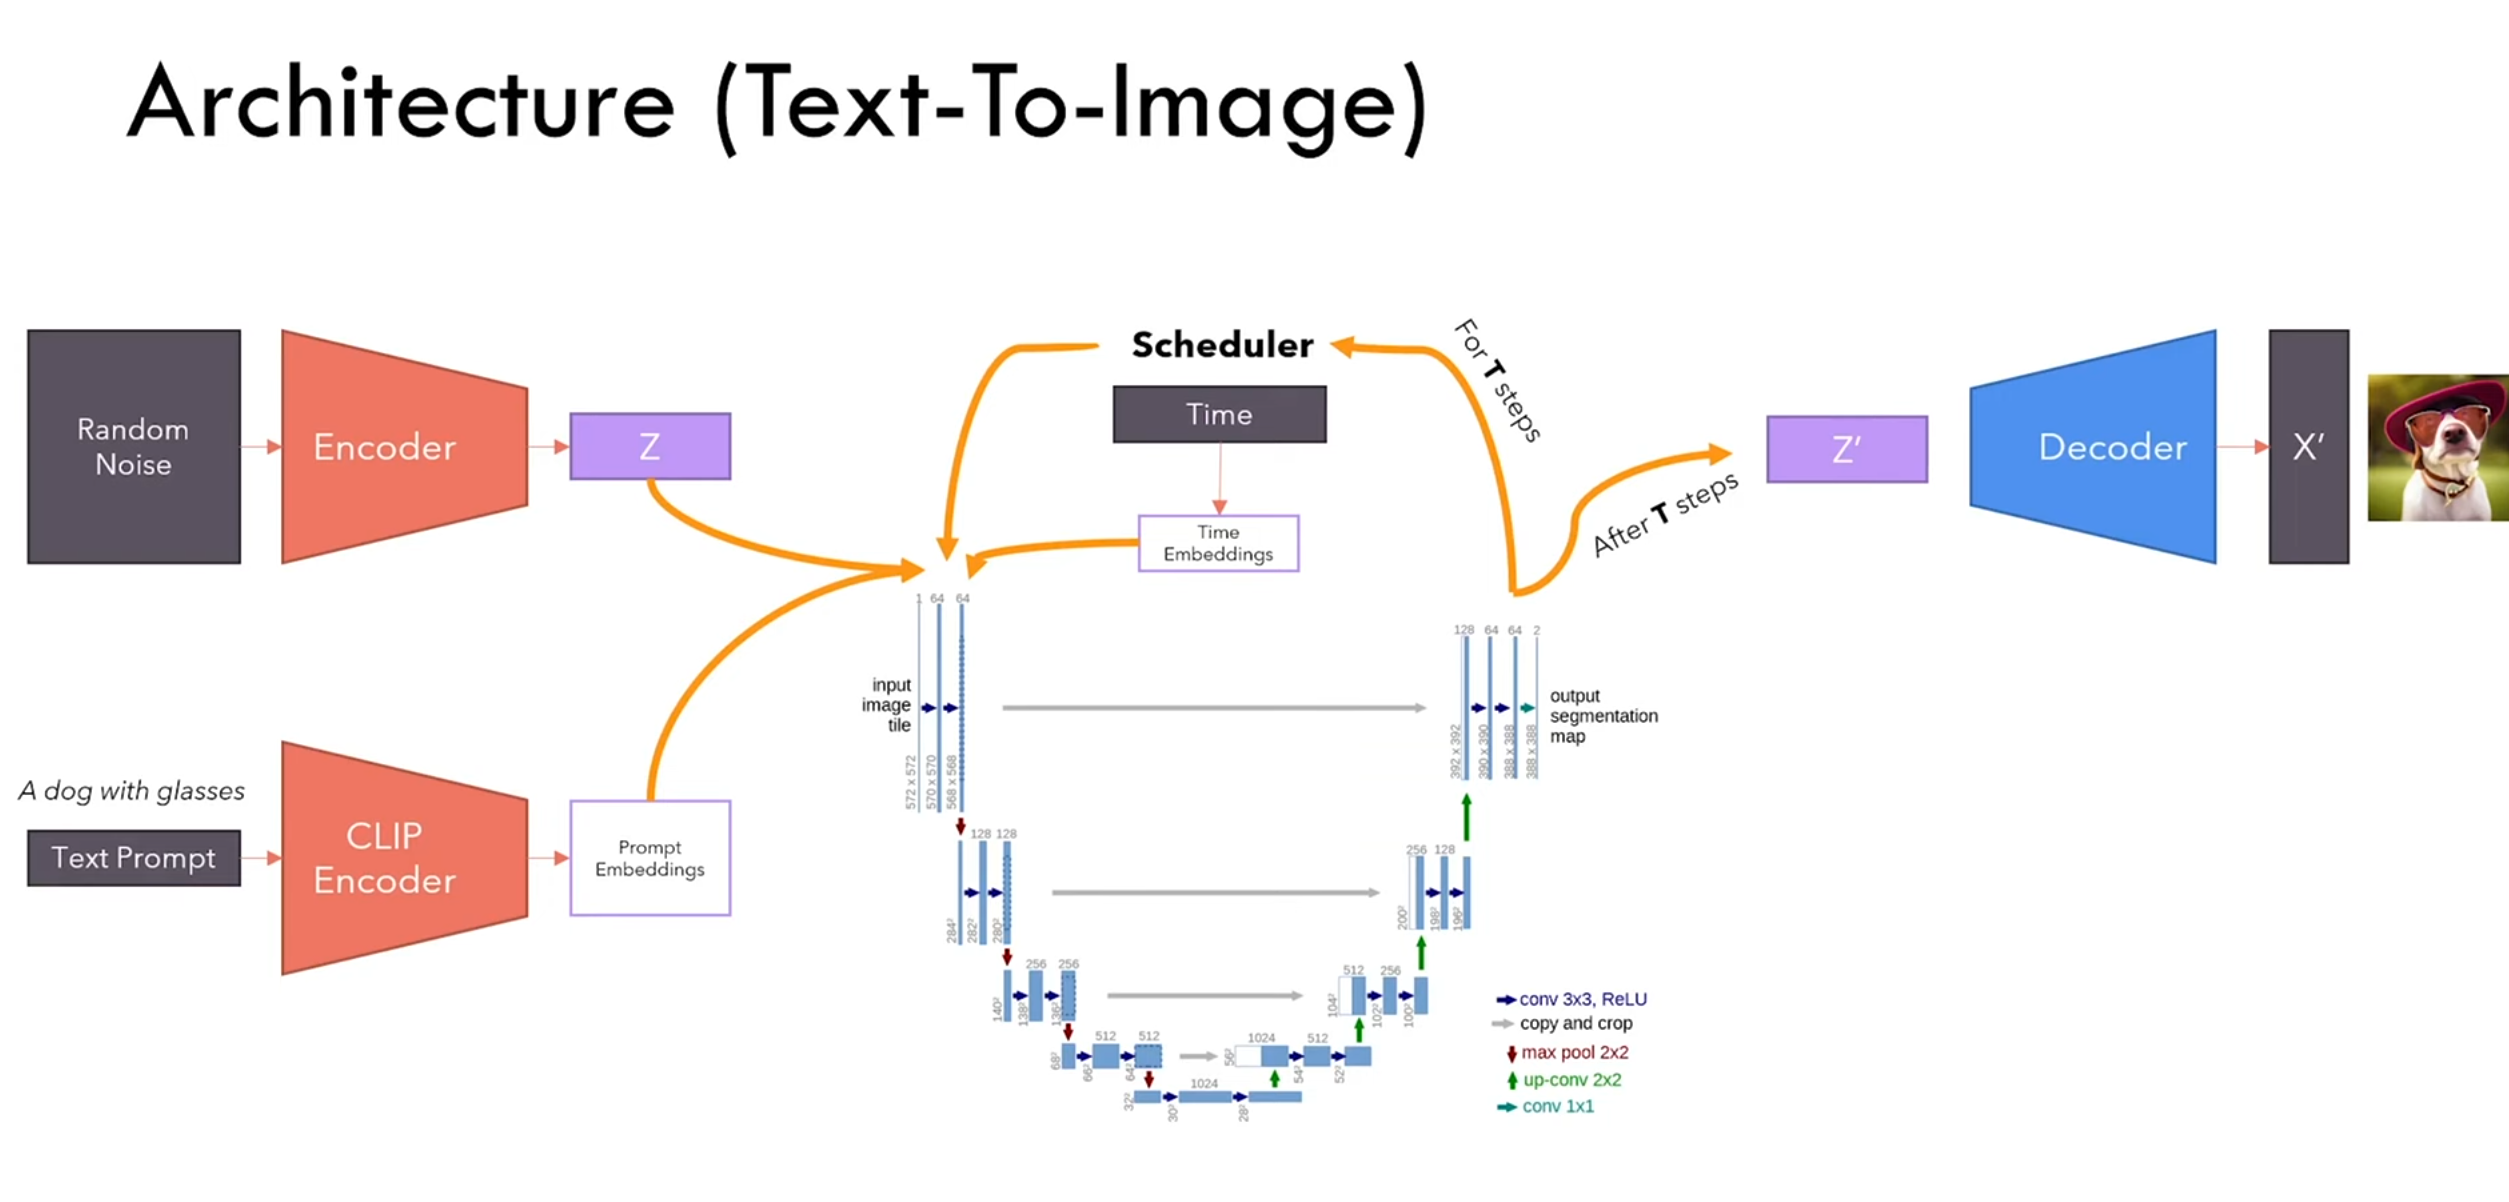

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class VAE_ResidualBlock(nn.Moudule):
    def _init_(self,in_channels,out_channels):
        super(VAE_ResidualBlock,self)._init_()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.groupnorm1 = nn.GroupNorm(32,in_channels)
        self.groupnorm2 = nn.GroupNorm(32,out_channels)

        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1)

In [1]:
#vae encoder
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE_Encoder(nn.Sequential):
    def __init__(self):
        super.__init__(
            #(batch_size,3,height,width) --> (batch_size,128,height,width)
            nn.Conv2d(3,128,kernel_size=3,padding=1),
            # (batch_size,128,height,width) --> (batch_size,128,height,width)
            VAE_ResidualBlock(128,128),
            # (batch_size,128,height,width) --> (batch_size,128,height,width)
            VAE_ResidualBlock(128,128),

            # (batch_size,128,height,width) --> (batch_size,128,height/2,width/2)
            nn.Conv2d(128,128,kernel_size=3,padding=0 ,stride=2),
            # (batch_size,128,height/2,width/2) --> (batch_size,256,height/2,width/2)
            VAE_ResidualBlock(128,256),
            # (batch_size,256,height/2,width/2) --> (batch_size,256,height/2,width/2)
            VAE_ResidualBlock(256,256),

            # (batch_size,256,height/2,width/2) --> (batch_size,256,height/4,width/4)
            nn.Conv2d(256,256,kernel_size=3  ,padding=0 ,stride=2),
            # (batch_size,256,height/4,width/4) --> (batch_size,512,height/4,width/4)
            VAE_ResidualBlock(256,512),
            # (batch_size,512,height/4,width/4) --> (batch_size,512,height/4,width/4)
            VAE_ResidualBlock(512,512),
            # (batch_size,512,height/4,width/4) --> (batch_size,512,height/8,width/8)
            nn.Conv2d(512,512,kernel_size=3  ,padding=0 ,stride=2),
            # (batch_size,512,height/8,width/8) --> (batch_size,512,height/8,width/8)
            VAE_ResidualBlock(512,512),
            VAE_ResidualBlock(512,512),

            VAE_ResidualBlock(512,512),
            # (batch_size,512,height/8,width/8) --> (batch_size,512,height/8,width/8)
            VAE_AttentionBlock(512),
            # (batch_size,512,height/8,width/8) --> (batch_size,512,height/8,width/8)
            VAE_ResidualBlock(512,512),

            # (batch_size,512,height/8,width/8) --> (batch_size,512,height/8,width/8)
            nn.GroupNorm(32,512),

            nn.SiLU(),

            # (batch_size,512,height/8,width/8) --> (batch_size,8,height/8,width/8)
            nn.Conv2d(512,8,kernel_size=3,padding=1),

            nn.Conv2d(8,8,kernel_size=1,padding=0),




        )

    def forward(self,x:torch.Tensor,noise:torch.Tensor)->torch.Tensor:
        #x: (batch_size,channel,height,width)
        #noise: (batch_size,output_channel,height/8,width/8)
        for module in self:
            if getattr(module,'stride',None) ==(2,2):
                x = F.pad(x,(0,1,0,1))
            x = module(x)

        # (batch_size,8,height/8,width/8) -->  two tensors of shapes (batch_size,4,height/8,width/8)
        mean,log_variance=torch.chunk(x,2,dim=1)

        log_variance=torch.clamp(log_variance,-30,20)
        variance=torch.exp(log_variance)
        stdev=torch.sqrt(variance)

        x=mean+stdev*noise

        x*=0.18215
        return x



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
